<div style="text-align: center; font-family: 'Arial', sans-serif;">
    <h1 style="color: #2c3e50;">Security and Privacy in Machine Learning</h1>
    <h3 style="color: #34495e;">Course Code: 40816</h3>
    <h3 style="color: #7f8c8d;">Instructor: Dr. Amir Mahdi Sadeghzadeh</h3>
    <h3 style="color: #95a5a6;">Sharif University of Technology, Iran</h3>
    <h3 style="color: #bdc3c7;">CE Department, Fall 2024</h3>
    <h3 style="color: #d35400;">Computer Assignment 5</h3>
    <h4 style="color: #e67e22;">Topic: Differential Privacy</h4>
</div>


<div style="text-align: left; font-family: 'Arial', sans-serif; font-size: 14px;">
    <h2 style="color: #3498db;">Introduction</h2>
    <p>This notebook contains the implementation for Computer Assignment 5 on Differential Privacy. Follow the instructions carefully and ensure your code adheres to the provided guidelines.</p>
</div>


<div style="text-align: left; font-family: 'Arial', sans-serif; font-size: 14px;">
    <h2 style="color: #9b59b6;">Personal Data</h2>
    <p>Please enter your student number, first name, and last name in the following cell.</p>
</div>

In [1]:
# Enter your personal details below
student_number = "99109252"  # Replace with your student number
first_name = "AmirHossein"      # Replace with your first name
last_name = "Haji Mohammad Rezaei"       # Replace with your last name

<div style="text-align: font-family: 'Arial', sans-serif;">
    <h1 style="color: #2c3e50;">Part 0: Introduction to Differential Privacy</h1>
</div>

<div style="text-align: font-family: 'Arial', sans-serif;">
    <h2 style="color: #34495e;">Question 0: Differential Privacy Definitions (5 Points)</h2>
</div>

Provide a brief summary of Differential Privacy principles. Define $\epsilon$-differential privacy and explain its significance in protecting individual data privacy.

`My answer`:
<p dir='rtl'>
محرمانگی تفاضلی تعهد ریاضی از طوی نگه‌دارنده داده مانند یک پایگاه داده می‌باشد که به افراد قول می‌دهد زمانی که از دادگان در یک آموزش و یا مطالعه استفاده بشود، با استفاده از هرگونه داده اضافی دیگر، نمیتوان اطلاعاتی در مورد تنها یک نمونه خاص از مجموعه داده بدست آورد. به همین صورت، معادل این رفتار این است که رفتار خروجی پایگاه داده‌هایی که اختلاف جزئی دارند، محدود است. اگر یک الگوریتم تصادفی را بر دو مجموعه داده X و Y که حداگثر در یک عنصر اختلاف دارند در نظر بگیریم، احتمال خروجی آنها نسبت به پیشامد S برابر است با:
</p>

$$P(M(X) \in S) \le e^{\epsilon}P(M(Y) \in S) + \delta$$

<p dir='rtl'>
در این حالت الگوریتم تصادفی M محرمانگی تفاضلی دارد. 
</p>


<div style="text-align: font-family: 'Arial', sans-serif;">
    <h1 style="color: #2c3e50;">Part 1: Mechanisms for Differential Privacy</h1>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml # need sklearn >= 0.22
import scipy as sp
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import ParameterGrid
from sklearn.svm import SVC
from sklearn.metrics import log_loss
from sklearn.preprocessing import LabelBinarizer

Below we provide a helper function to draw bar plots from pandas Series.

In [3]:
def bar_plot_pandas(series1, series2=None, label1="Series 1", label2="Series 2", title=""):
    '''
    Draws a bar plot of one Pandas Series, or two pandas Series with the same index

    Parameters
    ----------
    series1 : Series of float
        First input
    series2 : Series of float, optional
        Second input (with same index)
    label1 : string, optional
        Label for the first series
    label2 : string, optional
        Label for the second series
    title : string, optional
        Plot title
    '''
    if series2 is None:
        series1.plot.bar()
        plt.xlabel("Index")
        plt.ylabel("Values")
        plt.title(title if title else "Bar Plot")
        plt.legend([label1])
        plt.show()
    else:
        concat_series = pd.DataFrame({label1: series1, label2: series2}).reset_index()
        concat_series.plot.bar(x="index", y=[label1, label2], xlabel="", title=title)
        plt.xlabel("Index")
        plt.ylabel("Values")
        plt.title(title if title else "Comparison Bar Plot")
        plt.legend([label1, label2])
        plt.show()

<div style="text-align: font-family: 'Arial', sans-serif;">
    <h2 style="color: #2c3e50;">Dataset</h2>
</div>

We will be working with a dataset from the US Census (also known as the Adult dataset). You can read about the dataset [here](https://archive.ics.uci.edu/ml/datasets/census+income).

The following line loads the dataset from [OpenML](https://www.openml.org/) with the `fetch_openml` method of `sklearn`. The option `as_frame=True` (**requires sklearn version >= 0.22**) loads the dataset in `pandas DataFrame` format: this keeps the attributes in their original form and will be more convenient to work with. If you prefer working with a numpy array (not recommended), set `as_frame=False`.

In [4]:
# Fetching the Adult dataset from OpenML
dataset_handle = fetch_openml(name='adult', version=2, as_frame=True)
dataset = dataset_handle.frame

Take a look at the dataset, in particular the number of rows (individuals), the number of columns (attributes) and what they represent.

In [5]:
# Exploring the dataset
n, d = dataset.shape  # Number of rows and columns
print(f"Dataset contains {n} rows (individuals) and {d} columns (attributes).")
print("\nPreview of the dataset:")
print(dataset.head(4))

Dataset contains 48842 rows (individuals) and 15 columns (attributes).

Preview of the dataset:
    age  workclass    fnlwgt     education  education-num      marital-status  \
0  25.0    Private  226802.0          11th            7.0       Never-married   
1  38.0    Private   89814.0       HS-grad            9.0  Married-civ-spouse   
2  28.0  Local-gov  336951.0    Assoc-acdm           12.0  Married-civ-spouse   
3  44.0    Private  160323.0  Some-college           10.0  Married-civ-spouse   

          occupation relationship   race   sex  capital-gain  capital-loss  \
0  Machine-op-inspct    Own-child  Black  Male           0.0           0.0   
1    Farming-fishing      Husband  White  Male           0.0           0.0   
2    Protective-serv      Husband  White  Male           0.0           0.0   
3  Machine-op-inspct      Husband  Black  Male        7688.0           0.0   

   hours-per-week native-country  class  
0            40.0  United-States  <=50K  
1            50.0  Unit

<div style="text-align: font-family: 'Arial', sans-serif;">
    <h2 style="color: #2c3e50;">Question 1 (non-private queries) (7 Points)</h2>
</div>

Implement a function for each of these types of queries (without privacy) and test them on the dataset:
- **Simple count queries**: it takes as input a dataset (`DataFrame`), a categorical attribute (e.g., `"sex"`) and a value (e.g., `"Male"`), and returns how many rows in the dataset have the prescribed attribute value.
- **Averaging queries**: it takes as input a dataset and a numeric attribute (e.g., `"age"`), and returns the average value of this attribute in the dataset.
- **Histogram queries**: it takes as input a dataset and a categorical attribute (e.g., `"sex"`), and returns the histogram of counts for this attribute in the dataset (i.e., for each possible value of the attribute, how many rows have this value).

Reminder: for a DataFrame `df`, we can access the column corresponding to an attribute `attr` by `df[attr]`. The method `value_counts()` allows to build a histogram of a column. To plot a pandas Series `s` as a histogram, you can use `s.plot.bar()`.

Note: You can use the function `bar_plot_pandas` provided in the preamble to draw a bar plot of a pandas Series, which is useful to show histograms.

In [6]:
def count_query(df, attribute, value):
    '''
    Parameters
    ----------
    df : DataFrame
        Dataset
    attribute : string
        Name of an attribute with categorical values
    value : string or int
        Value of attribute to count

    Returns
    -------
    count : int
        The number of records with `attribute=value` in dataset `df`
    '''

    # TO COMPLETE
    return df[attribute].value_counts()[value]

In [7]:
def average_query(df, attribute):
    '''
    Parameters
    ----------
    df : DataFrame
        Dataset
    attribute : string
        Name of an attribute with numeric values

    Returns
    -------
    average : float
        The average value of `attribute` in dataset `df`
    '''

    return df[attribute].mean()

In [8]:
def histogram_query(df, attribute):
    '''
    Parameters
    ----------
    df : DataFrame
        Dataset
    attribute : string
        Name of an attribute with categorical values

    Returns
    -------
    histogram : array or Series of int
        The histogram of `attribute`, i.e., the number of times each value of `attribute` appears in `df`
    '''
    return df[attribute].value_counts()

<div style="text-align: font-family: 'Arial', sans-serif;">
    <h2 style="color: #2c3e50;">Question 2 (Laplace mechanism) (10 Points)</h2>
</div>

Implement the Laplace mechanism, i.e., a function which takes as input a (non-private) query output, the query's $\ell_1$ sensitivity, the desired value of $\epsilon$ and a random seed (for reproducibility), and returns a $\epsilon$-differentially private estimate of the query. To draw Laplace noise, check `np.random.laplace`. The function should work with queries that output a scalar (like simple count and averaging queries), as well as those that output a vector (like histogram queries).

In [9]:
def laplace_mechanism(q, s1, eps, random_state=None):
    '''
    Parameters
    ----------
    q : float or array/Series of float
        The non-private output of the query
    s1 : float
        The L1 sensitivity of the query
    eps : float
        Parameter epsilon of differential privacy
    random_state : int, optional (default=None)
        Random seed

    Returns
    -------
    private_q : float or array/Series of float
        An eps-DP evaluation of the query
    '''

    rng = np.random.RandomState(random_state)

    # TO COMPLETE

    scale = s1 / eps
    if hasattr(q, 'shape'): # query output is multi-dimensional
        noise = np.random.laplace(scale=scale, size=q.shape)
        return np.ceil(q + noise)
    else: # query output is a scalar
        noise = np.random.laplace(scale=scale)
        return q + noise

<div style="text-align: font-family: 'Arial', sans-serif;">
    <h2 style="color: #2c3e50;">Question 3 (Laplace mechanism on count queries) (8 Points)</h2>
</div>

We would like to use the Laplace mechanism to:
- privately count the number of males in the dataset
- generate a private histogram of the `"workclass"` attribute

What is the sensitivity of the query in each case? `Answer`: sensitivity of both of them is 1.

Run the Laplace mechanism with different values of $\epsilon$ and compute the $\ell_1$-error with respect to the true (non-private) output to see the effect on the utility and compare with the formal error bound seen in the lecture. Recall that the mechanism is random, so unless you fix the seed you will get a different result at each execution. Visually compare the private and non-private histograms using the function `bar_plot_pandas` provided at the beginning of the notebook.

Note: you may round the outputs of the private mechanism to make them integers if you like. This can be considered as post-processing and thus preserves DP (see Bonus Question 5 to go further on this aspect).

`Answer`:
<p dir='rtl'>
برای مقایسه ظاهری بین مقادیر خروجی محرمانه و غیرمحرمانه، تفاوت خاصی وجود ندارد و ترتیب مقایر مختلف حفظ خواهد شد. با استفاده از متریک l1 میتوان متوجه شد که برای بودجه محرمانگی پایین، چون نیاز به استفاده از نویز با مقادیر بزرگتر است، مقدار خطا l1 بیشتر خواهد شد. درنتیجه، داده خروجی تغییرات بیشتری به داده اصلی خواهد داشت.
</p>

In [13]:
def l1_error(a, b):
    '''
    Parameters
    ----------
    a : float or array/Series of float
        First input
    b : float or array/Series of float
        Second input

    Returns
    -------
    l1_error : float
        The L1 distance between `a` and `b`: ||a-b||_1
    '''

    if hasattr(a, 'shape'):
      return np.sum(np.abs(a.to_numpy() - b.to_numpy()))
    else:
      return abs(a-b)

# list of (query,sensitivity) tuples to loop over
queries = [
    (count_query(dataset, 'sex', 'Male'), 1),
    (histogram_query(dataset, 'workclass'), 1)
]

In [14]:
q, s = queries[0]

print(f'non-private value {q}')

for eps in [1., .1]:
  print(f'private value {laplace_mechanism(q, s, eps)} with ε = {eps}')

non-private value 32650
private value 32650.0 with ε = 1.0
private value 32660.0 with ε = 0.1


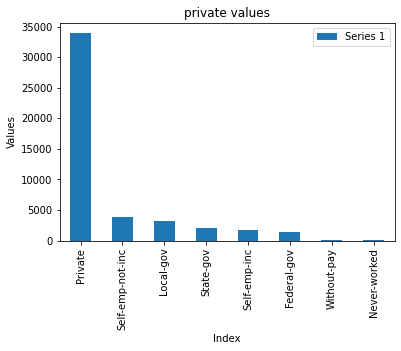

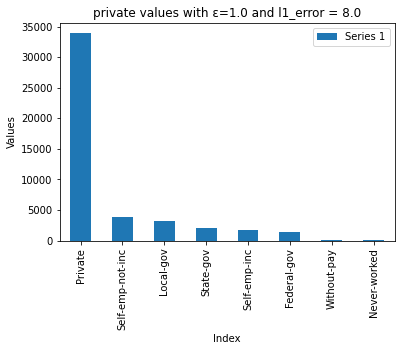

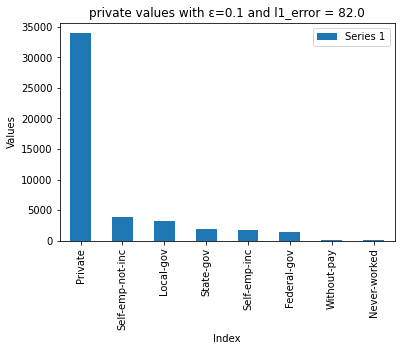

In [15]:
q, s = queries[1]

bar_plot_pandas(q, title='private values')

for eps in [1., .1]:
  q2 = laplace_mechanism(q, s, eps)
  bar_plot_pandas(q2, title=f'private values with ε={eps} and l1_error = {l1_error(q2, q)}')

<div style="text-align: font-family: 'Arial', sans-serif;">
    <h2 style="color: #2c3e50;">Question 4 (Gaussian mechanism and comparison with Laplace) (12 Points)</h2>
</div>

Implement the Gaussian mechanism (to draw Gaussian noise, check `np.random.normal`). Make an experimental comparison with the Laplace mechanism by plotting the privacy-utility trade-off for a 1D query of your choice. For the Gaussian mechanism, study the influence of $\delta$.

‍‍`Answer`:
<p dir='rtl'>
اثر مقدار delta همانطور که در نمودار مشاهده می‌کنید جزئی می‌باشد و نسبت به پارامتر epsilon باعث ایجاد تغییرات کمتری در مقدار خروجی خواهد شد.
</p>

In [16]:
def gaussian_mechanism(q, s2, eps, delta, random_state=None):
    '''
    Parameters
    ----------
    q : float or array/Series of float
        The non-private output of the query
    s2 : float
        The L2 sensitivity of the query
    eps : float
        Parameter epsilon of differential privacy
    delta : float
        Parameter delta of differential privacy
    random_state : int, optional (default=None)
        Random seed

    Returns
    -------
    private_q : float or array/Series of float
        An (eps,delta)-DP evaluation of the query
    '''

    rng = np.random.RandomState(random_state)

    # TO COMPLETE
    c = 1 + 2 * np.log(1.25 / delta)
    sigma = c * s2 / eps
    if hasattr(q, 'shape'): # query output is multi-dimensional
        noise = np.random.normal(scale=sigma, size=q.shape)
        return np.ceil(q + noise)
    else: # query output is a scalar
        noise = np.random.laplace(scale=sigma)
        return q + noise

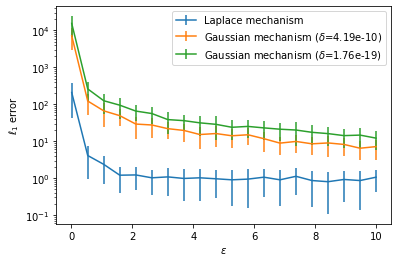

In [17]:
q = histogram_query(dataset, 'sex')
s = 1

eps_list = np.linspace(0.01, 10.0, num=20)
delta1 = 1. / n**2
delta2 = 1. / n**4
n_runs = 50

error = np.zeros((len(eps_list), 3, n_runs))

for i, eps in enumerate(eps_list):
    for r in range(n_runs):
        error[i, 0, r] = l1_error(q, laplace_mechanism(q, s, eps))
        error[i, 1, r] = l1_error(q, gaussian_mechanism(q, s, eps, delta1))
        error[i, 2, r] = l1_error(q, gaussian_mechanism(q, s, eps, delta2))
        pass

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.errorbar(eps_list, error[:, 0, :].mean(axis=1), error[:, 0, :].std(axis=1), label='Laplace mechanism')
ax.errorbar(eps_list, error[:, 1, :].mean(axis=1), error[:, 1, :].std(axis=1),
            label='Gaussian mechanism ($\delta$=' + "{:.2e}".format(delta1) + ')')
ax.errorbar(eps_list, error[:, 2, :].mean(axis=1), error[:, 2, :].std(axis=1),
            label='Gaussian mechanism ($\delta$=' + "{:.2e}".format(delta2) + ')')
plt.xlabel("$\epsilon$")
plt.ylabel("$\ell_1$ error")
ax.set_yscale('log')
ax.legend()

<div style="text-align: font-family: 'Arial', sans-serif;">
    <h1 style="color: #2c3e50;">Part 3: Applications of Differential Privacy</h1>
</div>

<div style="text-align: font-family: 'Arial', sans-serif;">
    <h2 style="color: #2c3e50;">Question 5 (contingency tables and the "paradox" of parallel composition) (8 Points)</h2>
</div>

We can go beyond histograms and build contingency tables across two (or even more) variables. Implement a function for such queries using `crosstab` from pandas, and use the Laplace mechanism to privately find out how people in the dataset break down according to the combination of `'gender'` and `'marital-status'`. You may need to adapt your implementation of Laplace to work with k-way tables (e.g., by using the method `applymap` together with a function that adds 1D Laplace noise).

Pushing this reasoning further, it may seem that there is a paradox because parallel composition gets us more information "for free" (e.g., we can build a k-way table over a large number of attributes that could ultimately reveal very precise information about individuals in the dataset, without increasing the privacy loss). This contradicts the principle that asking more things should cost something. Explain why there is in fact no paradox and what is the cost that one pays in this case (if needed, you can see what happens when privately releasing contingency tables across many columns).

`Answer`:
<p dir='rtl'>
نکته‌ای که در مورد این پارادوکس وجود دارد این است که با ایجاد جدول‌های چند‌متغیره، اضافه کردن نویز به آن باعث می‌شود که مفید بودن و دقت داده‌ها کاهش پیدا کند. به‌عبارتی، اگر جدول چند‌متغیره با تعداد زیادی متغیر ایجاد کنیم،‌جدولی sparse خواهیم داشت. در این حالت، با اینکه بودجه محرمانگی برحسب تعداد متغیر‌های استفاده‌شده، بین آنها تقسیم می‌شود، و در این حالت اضافه کردن نویز کم هم نیز همچنان باعث کاهش دقت داده‌ها خواهد شد.
</p>

In [10]:
def table_query(df, row_attr_list, col_attr_list):
    '''
    Parameters
    ----------
    df : DataFrame
        Dataset
    row_attr_list : list
        List of attributes
    col_attr_list : list
        List of attributes

    Returns
    -------
    cross_table : DataFrame
        Cross tabulation (contingency table) of `df` according to `row_attr_list` and `col_attr_list`
    '''

    cross_table = pd.crosstab(
        index=[df[attr] for attr in row_attr_list],
        columns=[df[attr] for attr in col_attr_list]
    )

    return cross_table

In [11]:
cross_table = table_query(dataset, ['sex'], ['marital-status'])

In [12]:
noisy_table = cross_table.applymap(lambda x: laplace_mechanism(x, 1, 1)).apply(np.floor)

In [13]:
cross_table

marital-status,Married-civ-spouse,Divorced,Never-married,Separated,Widowed,Married-spouse-absent,Married-AF-spouse
sex,,,,,,,
Female,2480,4001,7218,931,1233,304,25
Male,19899,2632,8899,599,285,324,12


In [14]:
noisy_table

marital-status,Married-civ-spouse,Divorced,Never-married,Separated,Widowed,Married-spouse-absent,Married-AF-spouse
sex,,,,,,,
Female,2479.0,3999.0,7219.0,931.0,1232.0,302.0,25.0
Male,19900.0,2632.0,8901.0,598.0,283.0,324.0,14.0


<div style="text-align: font-family: 'Arial', sans-serif;">
    <h2 style="color: #2c3e50;">Question 6 (Laplace mechanism on average queries) (9 Points)</h2>
</div>

We would like to use the Laplace mechanism to privately estimate the average age of people in the dataset. We assume that the number of people in the dataset is public.

1. Propose and implement simple practical strategies to compute or estimate the sensitivity of this query in the following two scenarios, and discuss the merits and/or drawbacks of your proposals:
  - You are the trusted curator: you have access to the raw dataset and would like to release an estimate of the average age of people in the dataset with differential privacy guarantees.
  - You are an external data analyst: you do not have access to the raw dataset but only to an API to send queries. You have to convince the trusted curator that the proposed sensitivity is safe.
2. Suggest some ideas regarding how we could change a bit the query to get a simple and safe bound on sensitivity, at the expense of possibly introducing some bias in the output. Implement the proposed solution. Hint: the method `clip` from pandas might be useful here.

‍‍‍‍`Answer:`
<p dir='rtl'>
برای تخمین حساسیت، در حالتی که نگه‌دارنده داده مورد اعتماد است، به راحتی میتوان از تقسیم اختلاف بیشترین سن در پایگاه داده و کم سن‌ترین تقسیم بر تعداد دادگان می‌توان حساسیت را بدست آورد که در این حالت باید از داده‌ها استفاده کرد اما خروجی دقیق می‌باشد.

در حالت دوم، کاربر خارجی می‌تواند بیشترین سن و کمترین سن را تخمین بزند و همین حساسیت را بدست آورد که در این حالت از داده‌ها استفاده نمی‌شود اما خروجی دقت کافی نسبت به حساسیت اصلی را ندارد. 

در حالت آخر، میتوانیم با محدود کردن سن افراد در پایگاه داده بر اساس کران بالا و پایین که کاربر خارجی می‌دهد، سن افراد را محدود کرد و سپس همین تخمین را انجام داد که این روش، حالت میانه را دارد اما ممکن است بایاس در خروجی داشته باشیم.
</p>

In [15]:
# Sensivity for trusted curator
def trusted_sensitivity(df):
  max_age, min_age = df['age'].max(), df['age'].min()
  return (max_age - min_age) / len(df)

# Sensivity for external analyst
def external_sensitivity(df, est_max_age=100, est_min_age=20):
  return (est_max_age - est_min_age) / len(df)

# Safe bounded sensivity
def safe_bound_sensitivity(df, est_max_age=100, est_min_age=20):
  clipped_ages = df['age'].clip(est_max_age, est_min_age)
  max_age, min_age = clipped_ages.max(), clipped_ages.min()
  return (max_age - min_age) / len(df)

In [16]:
laplace_mechanism(average_query(dataset, 'age'), trusted_sensitivity(dataset), 1.)

39.0

<div style="text-align: font-family: 'Arial', sans-serif;">
    <h2 style="color: #2c3e50;">Question 7 (average over a subset) (6 Points)</h2>
</div>

We would now like to compute the average age of divorced people. How can we use the Laplace mechanism to privately answer this query? Implement your solution.

In [20]:
def get_private_avg_divorced_age(df):
  selected_df = df[df['marital-status'] == 'Divorced']
  return laplace_mechanism(average_query(selected_df, 'age'), trusted_sensitivity(selected_df), 1.)

In [21]:
get_private_avg_divorced_age(dataset)

44.0

<div style="text-align: font-family: 'Arial', sans-serif;">
    <h2 style="color: #2c3e50;">Question 8 (non-private SGD) (17 Points)</h2>
</div>

In this question, we will implement our own simple version of SGD, as well as define our own sklearn-compatible $\ell_2$-regularized logistic regression estimator. This will be convenient when we will implement a differentially private version in Question 9.

Below, you are given several pieces of code:
1. A function `sgd` which implements SGD: it is meant to be generic in the sense that it takes as input a function `obj_and_grad` which computes the value and the gradient of the desired objective function. **This function has missing parts that you need to complete**.


2. A function `my_logistic_obj_and_grad` (adapted from [the version from sklearn](https://github.com/scikit-learn/scikit-learn/blob/0fb307bf39bbdacd6ed713c00724f8f871d60370/sklearn/linear_model/_logistic.py#L84)) which computes the value and gradient of the logistic regression problem. You do not need to modify this function.


3. A class `MySGDLogisticRegression` which defines a sklearn estimator for logistic regression, where the model is fit using SGD using the previous two functions. You do not need to modify this function.

Spend a bit of time to get familiar with the code provided, then complete the missing bits in the `sgd` function. Make sure it works by trying it on the binary classification dataset that you previously loaded.

In [22]:
def sgd(X, y, gamma, n_iter, obj_and_grad, theta_init, n_batch=1, freq_obj_eval=10,
        n_obj_eval=1000, random_state=None):
    """Stochastic Gradient Descent (SGD) algorithm

    Parameters
    ----------
    X : array, shape (n, d)
        The data
    y : array, shape (n,)
        Binary labels (-1, 1).
    gamma : float | callable
        The step size. Can be a constant float or a function
        that allows to have a variable step size
    n_iter : int
        The number of iterations
    obj_and_grad : callable
        A function which takes as a vector of shape (p,), a dataset of shape (n_batch, d)
        and a label vector of shape (n_batch,), and returns the objective value and gradient.
    theta_init : array, shape (p,)
        The initial value for the model parameters
    n_batch : int
        Size of the mini-batch to use at each iteration of SGD.
    freq_obj_eval : int
        Specifies the frequency (in number of iterations) at which we compute the objective
    n_obj_eval : int
        The number of points on which we evaluate the objective
    random_state : int
        Random seed to make the algorithm deterministic


    Returns
    -------
    theta : array, shape=(p,)
        The final value of the model parameters
    obj_list : list of length (n_iter / freq_obj_eval)
        A list containing the value of the objective function computed every freq_obj_eval iterations
    """

    rng = np.random.RandomState(random_state)
    n, d = X.shape
    p = theta_init.shape[0]

    theta = theta_init.copy()

    # if a constant step size was provided, we turn it into a constant function
    if not callable(gamma):
        def gamma_func(t):
            return gamma
    else:
        gamma_func = gamma

    # list to record the evolution of the objective (for plotting)
    obj_list = []
    # we draw a fixed subset of points to monitor the objective
    idx_eval = rng.randint(0, n, n_obj_eval)

    for t in range(n_iter):
        if t % freq_obj_eval == 0:
            # evaluate objective
            obj, _ = obj_and_grad(theta, X[idx_eval, :], y[idx_eval])
            obj_list.append(obj)

        # TO COMPLETE
        idx_train = rng.randint(0, n, n_batch)
        _, grad = obj_and_grad(theta, X[idx_train, :], y[idx_train])
        
        theta += gamma_func(t + 1) * grad


    return theta, obj_list

In [23]:
from sklearn.linear_model._base import LinearClassifierMixin, SparseCoefMixin, BaseEstimator
from sklearn.utils.extmath import log_logistic, safe_sparse_dot
from sklearn.linear_model._logistic import _intercept_dot
from scipy.special import expit
from sklearn.utils.validation import check_X_y

def my_logistic_obj_and_grad(theta, X, y, lamb):
    """Computes the value and gradient of the objective function of logistic regression defined as:
    min (1/n) \sum_i log_loss(theta;X[i,:],y[i]) + (lamb / 2) \|w\|^2,
    where theta = w (if no intercept), or theta = [w b] (if intercept)

    Parameters
    ----------
    theta_init : array, shape (d,) or (d+1,)
        The initial value for the model parameters. When an intercept is used, it corresponds to the last entry
    X : array, shape (n, d)
        The data
    y : array, shape (n,)
        Binary labels (-1, 1)
    lamb : float
        The L2 regularization parameter


    Returns
    -------
    obj : float
        The value of the objective function
    grad : array, shape (d,) or (d+1,)
        The gradient of the objective function
    """
    n_samples, n_features = X.shape
    grad = np.empty_like(theta)

    w, c, yz = _intercept_dot(theta, X, y)

    # Logistic loss is the negative of the log of the logistic function
    obj = -np.mean(log_logistic(yz)) + .5 * lamb * np.dot(w, w)

    z = expit(yz)
    z0 = (z - 1) * y

    grad[:n_features] = safe_sparse_dot(X.T, z0) / n_samples + lamb * w

    # Case where we fit the intercept
    if grad.shape[0] > n_features:
        grad[-1] = z0.sum() / n_samples
    return obj, grad


class MySGDLogisticRegression(BaseEstimator, LinearClassifierMixin, SparseCoefMixin):
    """Our own sklearn estimator for logistic regression defined as:
    min (1/n) \sum_i log_loss(theta;X[i,:],y[i]) + (lamb / 2) \|w\|^2,
    where theta = [w b]

    Parameters
    ----------
    gamma : float | callable
        The step size. Can be a constant float or a function
        that allows to have a variable step size
    n_iter : int
        The number of iterations
    lamb : float
        The L2 regularization parameter
    n_batch : int
        Size of the mini-batch to use at each iteration of SGD.
    freq_obj_eval : int
        Specifies the frequency (in number of iterations) at which we compute the objective
    n_obj_eval : int
        The number of points on which we evaluate the objectuve
    random_state : int
        Random seed to make the algorithm deterministic

    Attributes
    ----------
    coef_ : (p,)
        The weights of the logistic regression model.
    intercept_ : (1,)
        The intercept term of the logistic regression model.
    obj_list_: list of length (n_iter / freq_obj_eval)
        A list containing the value of the objective function computed every freq_loss_eval iterations
    """

    def __init__(self, gamma, n_iter, lamb=0, n_batch=1, freq_obj_eval=10, n_obj_eval=1000, random_state=None):
        self.gamma = gamma
        self.n_iter = n_iter
        self.lamb = lamb
        self.n_batch = n_batch
        self.freq_obj_eval = freq_obj_eval
        self.n_obj_eval = n_obj_eval
        self.random_state = random_state

    def fit(self, X, y):

        # WARNING: assumes labels are -1, 1
        X, y = check_X_y(X, y, accept_sparse='csr', dtype=[np.float64, np.float32], order="C")
        self.classes_ = np.unique(y)

        p = X.shape[1]
        theta_init = np.zeros(p+1) # initialize parameters to zero
        # define the function for value and gradient needed by SGD
        obj_grad = lambda theta, X, y: my_logistic_obj_and_grad(theta, X, y, lamb=self.lamb)
        theta, obj_list = sgd(X, y, self.gamma, self.n_iter, obj_grad, theta_init, self.n_batch,
                              self.freq_obj_eval, self.n_obj_eval, self.random_state)

        # save the learned model into the appropriate quantities used by sklearn
        self.intercept_ = np.expand_dims(theta[-1], axis=0)
        self.coef_ = np.expand_dims(theta[:-1], axis=0)

        # also save list of objective values during optimization for plotting
        self.obj_list_ = obj_list

        return self

In [24]:
X, y = fetch_openml(name='adult', version=2, return_X_y=True, as_frame=False)
idx = np.isnan(X)
X[idx] = 0

normalizer = Normalizer()
X = normalizer.transform(X)


lb = LabelBinarizer()
lb.fit(y)
y = lb.transform(y).squeeze(1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)



Test accuracy 0.7641146544236258


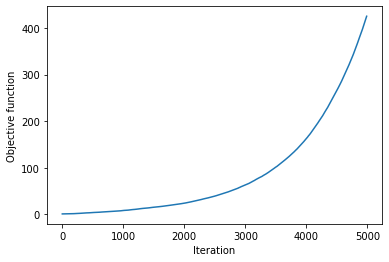

In [25]:
lamb = 0.01
n_iter = 5000
n_batch = 1
gamma = 0.05
# gamma = lambda t: 1 / np.sqrt(t)

mlr = MySGDLogisticRegression(gamma, n_iter, lamb, n_batch=n_batch, random_state=None)
mlr.fit(X_train, y_train)
print("Test accuracy", mlr.score(X_test, y_test))

obj_list = mlr.obj_list_
iter_list = np.arange(len(obj_list)) * mlr.freq_obj_eval
plt.plot(iter_list, obj_list)
plt.xlabel("Iteration")
plt.ylabel("Objective function")
plt.show()

<div style="text-align: font-family: 'Arial', sans-serif;">
    <h2 style="color: #2c3e50;">Question 9 (private SGD) (18 Points)</h2>
</div>

We will now implement and experiment with DP-SGD:
1. Following the model of the function `sgd`, implement a new function `private_sgd` which implements DP-SGD **with mini-batch size of 1 and no regularization**. It can take as input the desired value of $\epsilon$ and $\delta$ for the $(\epsilon,\delta)$-DP, or alternatively the standard deviation of the Gaussian noise to add at each iteration. Note: you do not need to make the objective plotting part private (this is only for monitoring).


2. Following the model of the class `MySGDLogisticRegression`, implement a new class `MyPrivateSGDLogisticRegression` which implements differentially private logistic regression trained using your DP-SGD implementation above.


3. Experiment with different values of $\epsilon$ and $\delta$, number of iterations and step size, and study the effect on the convergence of SGD as well as the test accuracy of the resulting model. Describe your observations. How should the number of iterations depend on the level of privacy? How can we choose the number of iterations and step size in practice?

`Answer:`

<p dir='rtl'>
در اینجا برحسب حالات مختلف پارمتر‌های epsilon و delta آموزش انجام شده است. همانطور که مشاهده می‌کنید، در مقدار نویز ایجاد‌شده، پارمتر epsilon نقش مهم‌تری دارد و پارامتر delta تاثیر کمتری دارد (از جهت اندازه آن نیز می‌باشد). همچنین در مدل دقت‌ها همه آنها به یک دقت می‌رسند که شاید به‌دلیل سادگی وظیفه مجموعه داده باشد. 

برای انتخاب تعداد دور یادگیری ، میتوان از خاصیت ترکیبی محرمانگی استفاده کرد، از آنجایی که محرمانگی کل الگوریتم به صورت زیر می‌باشد، با تعیین محرمانگی مورد نظر میتوان تعداد دور مورد نظر و قدم اجرا در الگوریتم را بدست آورد:
</p>

$$O(q\epsilon\sqrt{Tlog(\frac{1}{\delta})}, Tq\delta)$$

In [26]:
def private_sgd(X, y, epsilon, delta, gamma, n_iter, obj_and_grad, theta_init, n_batch=1, freq_obj_eval=10,
        n_obj_eval=1000, random_state=None):
    """Stochastic Gradient Descent (SGD) algorithm

    Parameters
    ----------
    X : array, shape (n, d)
        The data
    y : array, shape (n,)
        Binary labels (-1, 1).
    gamma : float | callable
        The step size. Can be a constant float or a function
        that allows to have a variable step size
    n_iter : int
        The number of iterations
    obj_and_grad : callable
        A function which takes as a vector of shape (p,), a dataset of shape (n_batch, d)
        and a label vector of shape (n_batch,), and returns the objective value and gradient.
    theta_init : array, shape (p,)
        The initial value for the model parameters
    n_batch : int
        Size of the mini-batch to use at each iteration of SGD.
    freq_obj_eval : int
        Specifies the frequency (in number of iterations) at which we compute the objective
    n_obj_eval : int
        The number of points on which we evaluate the objective
    random_state : int
        Random seed to make the algorithm deterministic


    Returns
    -------
    theta : array, shape=(p,)
        The final value of the model parameters
    obj_list : list of length (n_iter / freq_obj_eval)
        A list containing the value of the objective function computed every freq_obj_eval iterations
    """

    rng = np.random.RandomState(random_state)
    n, d = X.shape
    p = theta_init.shape[0]

    q = n_batch / len(X)
    sigma = (q * np.sqrt(n_iter * np.log(1 / delta))) / epsilon
    C = 2

    theta = theta_init.copy()

    # if a constant step size was provided, we turn it into a constant function
    if not callable(gamma):
        def gamma_func(t):
            return gamma
    else:
        gamma_func = gamma

    # list to record the evolution of the objective (for plotting)
    obj_list = []
    # we draw a fixed subset of points to monitor the objective
    idx_eval = rng.randint(0, n, n_obj_eval)

    for t in range(n_iter):
        if t % freq_obj_eval == 0:
            # evaluate objective
            obj, _ = obj_and_grad(theta, X[idx_eval, :], y[idx_eval])
            obj_list.append(obj)

        # TO COMPLETE
        idx_train = rng.randint(0, n, n_batch)
        _, grad = obj_and_grad(theta, X[idx_train, :], y[idx_train])

        grad = grad / np.maximum(np.ones(grad.shape), np.linalg.norm(grad) / C)

        grad += np.random.normal(scale=sigma * C, size=grad.shape)
        theta += gamma_func(t + 1) * grad


    return theta, obj_list

In [27]:
class MyPrivateSGDLogisticRegression(BaseEstimator, LinearClassifierMixin, SparseCoefMixin):
    """Our own sklearn estimator for logistic regression defined as:
    min (1/n) \sum_i log_loss(theta;X[i,:],y[i]) + (lamb / 2) \|w\|^2,
    where theta = [w b]

    Parameters
    ----------
    gamma : float | callable
        The step size. Can be a constant float or a function
        that allows to have a variable step size
    n_iter : int
        The number of iterations
    lamb : float
        The L2 regularization parameter
    n_batch : int
        Size of the mini-batch to use at each iteration of SGD.
    freq_obj_eval : int
        Specifies the frequency (in number of iterations) at which we compute the objective
    n_obj_eval : int
        The number of points on which we evaluate the objectuve
    random_state : int
        Random seed to make the algorithm deterministic

    Attributes
    ----------
    coef_ : (p,)
        The weights of the logistic regression model.
    intercept_ : (1,)
        The intercept term of the logistic regression model.
    obj_list_: list of length (n_iter / freq_obj_eval)
        A list containing the value of the objective function computed every freq_loss_eval iterations
    """

    def __init__(self, epsilon, delta, gamma, n_iter, lamb=0, n_batch=1, freq_obj_eval=10, n_obj_eval=1000, random_state=None):
        self.epsilon = epsilon
        self.delta = delta
        self.gamma = gamma
        self.n_iter = n_iter
        self.lamb = lamb
        self.n_batch = n_batch
        self.freq_obj_eval = freq_obj_eval
        self.n_obj_eval = n_obj_eval
        self.random_state = random_state

    def fit(self, X, y):

        # WARNING: assumes labels are -1, 1
        X, y = check_X_y(X, y, accept_sparse='csr', dtype=[np.float64, np.float32], order="C")
        self.classes_ = np.unique(y)

        p = X.shape[1]
        theta_init = np.zeros(p+1) # initialize parameters to zero
        # define the function for value and gradient needed by SGD
        obj_grad = lambda theta, X, y: my_logistic_obj_and_grad(theta, X, y, lamb=self.lamb)
        theta, obj_list = private_sgd(X, y, self.epsilon, self.delta, self.gamma, self.n_iter, obj_grad, theta_init, self.n_batch,
                              self.freq_obj_eval, self.n_obj_eval, self.random_state)

        # save the learned model into the appropriate quantities used by sklearn
        self.intercept_ = np.expand_dims(theta[-1], axis=0)
        self.coef_ = np.expand_dims(theta[:-1], axis=0)

        # also save list of objective values during optimization for plotting
        self.obj_list_ = obj_list

        return self

In [33]:
X, y = fetch_openml(name='adult', version=2, return_X_y=True, as_frame=False)
idx = np.isnan(X)
X[idx] = 0

normalizer = Normalizer()
X = normalizer.transform(X)


lb = LabelBinarizer()
lb.fit(y)
y = lb.transform(y).squeeze(1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Test accuracy 0.7641146544236258


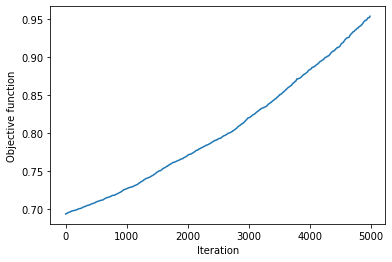

In [34]:
lamb = 0
n_iter = 5000
n_batch = 1
gamma = 0.001
epsilon = 0.25
delta = 10 ** (-5)
# gamma = lambda t: 1 / np.sqrt(t)

mlr = MyPrivateSGDLogisticRegression(epsilon, delta, gamma, n_iter, lamb, n_batch=n_batch, random_state=None)
mlr.fit(X_train, y_train)
print("Test accuracy", mlr.score(X_test, y_test))

obj_list = mlr.obj_list_
iter_list = np.arange(len(obj_list)) * mlr.freq_obj_eval
plt.plot(iter_list, obj_list)
plt.xlabel("Iteration")
plt.ylabel("Objective function")
plt.show()

Test accuracy 0.7641146544236258


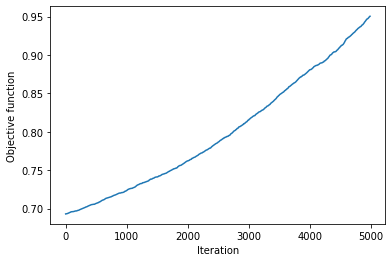

In [37]:
lamb = 0
n_iter = 5000
n_batch = 1
gamma = 0.001
epsilon = 0.25
delta = 10 ** (-5)
# gamma = lambda t: 1 / np.sqrt(t)

mlr = MyPrivateSGDLogisticRegression(epsilon, delta, gamma, n_iter, lamb, n_batch=n_batch, random_state=None)
mlr.fit(X_train, y_train)
print("Test accuracy", mlr.score(X_test, y_test))

obj_list = mlr.obj_list_
iter_list = np.arange(len(obj_list)) * mlr.freq_obj_eval
plt.plot(iter_list, obj_list)
plt.xlabel("Iteration")
plt.ylabel("Objective function")
plt.show()

Test accuracy 0.7641146544236258


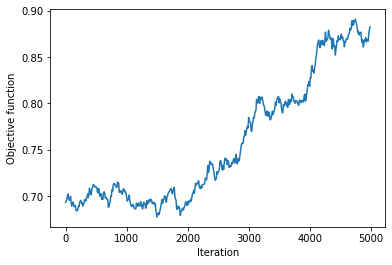

In [31]:
lamb = 0
n_iter = 5000
n_batch = 1
gamma = 0.001
epsilon = 0.0025
delta = 10 ** (-5)
# gamma = lambda t: 1 / np.sqrt(t)

mlr = MyPrivateSGDLogisticRegression(epsilon, delta, gamma, n_iter, lamb, n_batch=n_batch, random_state=None)
mlr.fit(X_train, y_train)
print("Test accuracy", mlr.score(X_test, y_test))

obj_list = mlr.obj_list_
iter_list = np.arange(len(obj_list)) * mlr.freq_obj_eval
plt.plot(iter_list, obj_list)
plt.xlabel("Iteration")
plt.ylabel("Objective function")
plt.show()

<div style="text-align: font-family: 'Arial', sans-serif;">
    <h2 style="color: #2c3e50;">Optional: Question 10 (federated learning with DP: DP-SGD in the distributed model) (20 Points)</h2>
</div>

Enough with these simple queries! Let's train a machine learning model in the federated learning, in which $n$ participants with their own datasets collaborate to train a joint model. Each participant $i$ wants to ensure that the algorithm satisfies $(\epsilon,\delta)$-DP with respect to his/her own dataset $D_i$. This is sometimes referred to as the distributed model of DP. Note that if each participant has a dataset of size 1 then this is exactly local DP. However, the privacy-utility trade-off will be better when participants have more data points, which is what we consider below.

The following code loads the US Census dataset in one-hot encoded version. Feel free to use another binary classification dataset of your choice instead.

In [38]:
X, y = fetch_openml(name='a9a', version=1, return_X_y=True, as_frame=False)
normalizer = Normalizer()
X = normalizer.transform(X)
m, d = X.shape
print(m, d)

48842 123


Consider a setting with $n=5$ participants. To simulate the federated learning setting, we will split the dataset in $n$ local datasets of roughly equal size. To do this, we use `sklearn.model_selection.KFold`.

We would now like to train a logistic regression classifier with DP-SGD in the federated setting. For simplicity of exposition, assume the presence of an *untrusted* aggregator. The algorithm follows an interative process, where each iteration consists of the following steps:
1. The trusted aggregator sends the current parameters of the model to the participants.

2. Each participant $i$ computes a stochastic gradient using a mini-batch from his local dataset $D_i$, adds Gaussian noise locally to ensure DP, and sends it to the untrusted aggregator.

3. The untrusted aggregator averages these gradients and use the result to update the model with a gradient step.

How much Gaussian noise should each participant add at each iteration to ensure an $(\epsilon,\delta)$-DP guarantee for the entire algorithm?

Adapt your centralized DP-SGD code from the previous practical to simulate this federated learning version. Compare the utility with the centralized version, studying in particular the effect of the number of participants.

Suppose that the local dataset sizes are imbalanced across participants. How does this affect the Gaussian noise added by each participant? How does this effect the utility? Suggest an appropriate weighted aggregation scheme to mitigate this.

`Answer:`

<p dir='rtl'>
در رابطه با نویز اضافه‌شده به هر داده، در اینجا بودجه محرمانگی برای مجموعه داده هر شرکت‌کننده مان epsilon در نظر گرفته می‌شود زیرا که مجموعه داده از یکدیگر مجزا هستند و همه گرادیان‌های مربوط به داده‌های مختلف در مدل نهایی با هم تجمیع می‌شوند (همانند روش ترکیب موازی برای جدول چند‌متغیره epsilon مستقل از تعداد شرکت‌کننده بریا هرکدام از آنها خواهد بود.)

با افزایش تعداد شرکت‌کننده‌ها، همانطور که در نتیجه دیده می‌شود، دقت مدل افزایش می‌یابد، زیرا اگر تعداد شرکت‌کنندگان زیاد شود، اثر نویز اضافه‌شده در هر شرکت‌کننده نسبت به حالتی که تعداد شرکت‌کننده‌ها کم است، کاهش می‌یابد.

برای حالتی که مجموعه داده شرکت‌کنندگان نسبت به یکدیگر متوازن نمی‌باشد، اتفاقی که می‌افتد این است که برای شرکت‌کننده با تعداد کم نمونه داده، جساسیت اختلاف گرادیان‌ها بالاتر بوده و در نتیجه نیاز به نویز با اندازه بزرگتر وجود دارد. برای رفع این مشکل می‌توان از نرمال‌سازی میانگین گرفتن گرادیان‌ها برای مدل نهایی استفاده کرد و گرادیان برای هر شرکت‌کننده متناسب با اندازه مجموعه داده آن شرکت‌کننده با یکدیگر جمع کنیم، تا اهمیت گرادیان برای شرکت‌کننده‌های با تعداد بیشتر نمونه داده افزایش پیدا کند.
</p>

In [59]:
def local_gradient(X, y, epsilon, delta, obj_and_grad, theta_init, n_batch=1, random_state=None):


    rng = np.random.RandomState(random_state)
    n, d = X.shape

    q = n_batch / n
    sigma = (q * np.sqrt(n_iter * np.log(1 / delta))) / epsilon
    C = 2

    theta = theta_init.copy()
    # TO COMPLETE
    idx_train = rng.randint(0, n, n_batch)
    _, grad = obj_and_grad(theta, X[idx_train, :], y[idx_train])
    grad = grad / np.maximum(np.ones(grad.shape), np.linalg.norm(grad) / C)
    grad += np.random.normal(scale=sigma * C, size=grad.shape)

    return grad


def private_fl_sgd(features, labels, epsilon, delta, gamma, n_iter, obj_and_grad, theta_init, n_batch=1, freq_obj_eval=10,
        n_obj_eval=1000, random_state=None):
    
    theta = theta_init.copy()

    # if a constant step size was provided, we turn it into a constant function
    if not callable(gamma):
        def gamma_func(t):
            return gamma
    else:
        gamma_func = gamma

    for t in range(n_iter):
        
        grad = np.zeros(theta.shape)
        for i in range(5):
            grad += local_gradient(features[i], labels[i], epsilon, delta, obj_and_grad, theta_init)
        
        grad /= len(features.keys())
        theta += gamma_func(t + 1) * grad
    return theta


class MyPrivateFLSGDLogisticRegression(BaseEstimator, LinearClassifierMixin, SparseCoefMixin):
    """Our own sklearn estimator for logistic regression defined as:
    min (1/n) \sum_i log_loss(theta;X[i,:],y[i]) + (lamb / 2) \|w\|^2,
    where theta = [w b]

    Parameters
    ----------
    gamma : float | callable
        The step size. Can be a constant float or a function
        that allows to have a variable step size
    n_iter : int
        The number of iterations
    lamb : float
        The L2 regularization parameter
    n_batch : int
        Size of the mini-batch to use at each iteration of SGD.
    freq_obj_eval : int
        Specifies the frequency (in number of iterations) at which we compute the objective
    n_obj_eval : int
        The number of points on which we evaluate the objectuve
    random_state : int
        Random seed to make the algorithm deterministic

    Attributes
    ----------
    coef_ : (p,)
        The weights of the logistic regression model.
    intercept_ : (1,)
        The intercept term of the logistic regression model.
    obj_list_: list of length (n_iter / freq_obj_eval)
        A list containing the value of the objective function computed every freq_loss_eval iterations
    """

    def __init__(self, epsilon, delta, gamma, n_iter, lamb=0, n_batch=1, freq_obj_eval=10, n_obj_eval=1000, random_state=None):
        self.epsilon = epsilon
        self.delta = delta
        self.gamma = gamma
        self.n_iter = n_iter
        self.lamb = lamb
        self.n_batch = n_batch
        self.freq_obj_eval = freq_obj_eval
        self.n_obj_eval = n_obj_eval
        self.random_state = random_state

    def fit(self, features, labels):
        self.classes_ = np.unique(labels[0])

        obj_grad = lambda theta, X, y: my_logistic_obj_and_grad(theta, X, y, lamb=self.lamb)
        p = features[0].shape[1]
        theta_init = np.zeros((p+1))
        theta = private_fl_sgd(features, labels, self.epsilon, self.delta, self.gamma, self.n_iter, obj_grad, theta_init, self.n_batch,
                              self.freq_obj_eval, self.n_obj_eval, self.random_state)

        # save the learned model into the appropriate quantities used by sklearn
        self.intercept_ = np.expand_dims(theta[-1], axis=0)
        self.coef_ = np.expand_dims(theta[:-1], axis=0)

        

        return self



In [60]:
n = 5
features = {}
labels = {}
for i, idx in enumerate(KFold(n_splits=n, shuffle=True).split(X)):
    features[i] = X[idx[1],:]
    labels[i] = y[idx[1]]

for i in range(n):
    print("Dataset of participant " + str(i) + ":", features[i].shape, labels[i].shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Dataset of participant 0: (9769, 123) (9769,)
Dataset of participant 1: (9769, 123) (9769,)
Dataset of participant 2: (9768, 123) (9768,)
Dataset of participant 3: (9768, 123) (9768,)
Dataset of participant 4: (9768, 123) (9768,)


In [61]:
lamb = 0
n_iter = 5000
n_batch = 10
gamma = 0.05
epsilon = 0.25
delta = 10 ** (-5)
# gamma = lambda t: 1 / np.sqrt(t)

mlr = MyPrivateFLSGDLogisticRegression(epsilon, delta, gamma, n_iter, lamb, n_batch=n_batch, random_state=None)
mlr.fit(features, labels)
print("Test accuracy", mlr.score(X_test, y_test))

Test accuracy 0.24283409852339


In [62]:
n = 1000
features = {}
labels = {}
for i, idx in enumerate(KFold(n_splits=n, shuffle=True).split(X)):
    features[i] = X[idx[1],:]
    labels[i] = y[idx[1]]

'''
for i in range(n):
    print("Dataset of participant " + str(i) + ":", features[i].shape, labels[i].shape)
'''

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [65]:
lamb = 0
n_iter = 5000
n_batch = 10
gamma = 0.05
epsilon = 0.25
delta = 10 ** (-5)
# gamma = lambda t: 1 / np.sqrt(t)

mlr = MyPrivateFLSGDLogisticRegression(epsilon, delta, gamma, n_iter, lamb, n_batch=n_batch, random_state=None)
mlr.fit(features, labels)
print("Test accuracy", mlr.score(X_test, y_test))

Test accuracy 0.24680481449311328
